## **21022008_NguyenHuuTho**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import the necessary packages
import os
# define the base path to the input dataset and then use it to derive
# the path to the images directory and annotation CSV file
BASE_PATH = "/content/drive/MyDrive/NLMH_Thuchanh/Week13_Thuchanh7/dataset"
IMAGES_PATH = os.path.sep.join([BASE_PATH, "images"])
ANNOTS_PATH = os.path.sep.join([BASE_PATH, "labels_airplanes_tiny.csv"])

In [ ]:
# define the path to the base output directory
BASE_OUTPUT = "/content/drive/MyDrive/NLMH_Thuchanh/Week13_Thuchanh7/output"
# define the path to the output serialized model, model training plot,
# and testing image filenames
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "detector.h5"])
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])
TEST_FILENAMES = os.path.sep.join([BASE_OUTPUT, "test_images.txt"])

In [ ]:
# initialize our initial learning rate, number of epochs to train
# for, and the batch size
INIT_LR = 1e-4
NUM_EPOCHS = 100
BATCH_SIZE = 32

In [ ]:
# import the necessary packages
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

In [ ]:
# load the contents of the CSV annotations file
print("[INFO] loading dataset...")
rows = open(ANNOTS_PATH).read().strip().split("\n")
# initialize the list of data (images), our target output predictions
# (bounding box coordinates), along with the filenames of the
# individual images
data = []
targets = []
filenames = []

print(rows)
print(data)
print(targets)
print(filenames)

[INFO] loading dataset...
['image_0001.jpg,49,28,349,136', 'image_0002.jpg,58,33,341,152', 'image_0003.jpg,48,35,331,136', 'image_0004.jpg,48,33,340,139', 'image_0004.jpg,307,50,360,111', 'image_0004.jpg,311,49,392,109', 'image_0005.jpg,49,18,339,144', 'image_0006.jpg,48,24,342,124', 'image_0007.jpg,49,24,343,122', 'image_0008.jpg,47,29,342,118', 'image_0009.jpg,53,31,342,136', 'image_0010.jpg,56,32,334,104', 'image_0011.jpg,58,34,339,129', 'image_0012.jpg,48,25,342,122', 'image_0013.jpg,50,30,344,143', 'image_0014.jpg,54,34,347,121', 'image_0015.jpg,60,43,352,163', 'image_0016.jpg,57,53,328,137', 'image_0017.jpg,60,33,346,142', 'image_0018.jpg,56,31,347,148', 'image_0019.jpg,49,31,341,147', 'image_0020.jpg,45,30,346,163', 'image_0021.jpg,46,24,346,127', 'image_0022.jpg,47,30,343,129', 'image_0023.jpg,49,22,342,121', 'image_0024.jpg,42,24,342,105', 'image_0025.jpg,55,30,341,140', 'image_0026.jpg,59,30,337,128', 'image_0027.jpg,53,26,347,125', 'image_0028.jpg,55,27,343,115', 'image_0029

In [ ]:
# loop over the rows
for row in rows:
	# break the row into the filename and bounding box coordinates
	row = row.split(",")
	(filename, startX, startY, endX, endY) = row
	# derive the path to the input image, load the image (in OpenCV
	# format), and grab its dimensions
	imagePath = os.path.sep.join([IMAGES_PATH, filename])
	image = cv2.imread(imagePath)
	(h, w) = image.shape[:2]
	# scale the bounding box coordinates relative to the spatial
	# dimensions of the input image
	startX = float(startX) / w
	startY = float(startY) / h
	endX = float(endX) / w
	endY = float(endY) / h
	# load the image and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	# update our list of data, targets, and filenames
	data.append(image)
	targets.append((startX, startY, endX, endY))
	filenames.append(filename)

In [ ]:
# convert the data and targets to NumPy arrays, scaling the input
# pixel intensities from the range [0, 255] to [0, 1]
data = np.array(data, dtype="float32") / 255.0
targets = np.array(targets, dtype="float32")
# partition the data into training and testing splits using 90% of
# the data for training and the remaining 10% for testing
split = train_test_split(data, targets, filenames, test_size=0.10,
	random_state=42)
# unpack the data split
(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]
(trainFilenames, testFilenames) = split[4:]
# write the testing filenames to disk so that we can use then
# when evaluating/testing our bounding box regressor
print("[INFO] saving testing filenames...")
f = open(TEST_FILENAMES, "w")
f.write("\n".join(testFilenames))
f.close()

[INFO] saving testing filenames...


In [ ]:
# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG19(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
# freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable = False
# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)
# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid")(bboxHead)
# construct the model we will fine-tune for bounding box regression
model = Model(inputs=vgg.input, outputs=bboxHead)

80134624/80134624 [==============================] - 3s 0us/step


In [ ]:
# initialize the optimizer, compile the model, and show the model
# summary
opt = Adam(lr=INIT_LR)
# model.compile(loss="mse", optimizer=opt, metrics=['accuracy'])
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy']) # Điều chỉnh để lấy confusion matrix
print(model.summary())
# train the network for bounding box regression
print("[INFO] training bounding box regressor...")
H = model.fit(
	trainImages, trainTargets,
	validation_data=(testImages, testTargets),
	batch_size=BATCH_SIZE,
	epochs=NUM_EPOCHS,
	verbose=1)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

[INFO] saving object detector model...


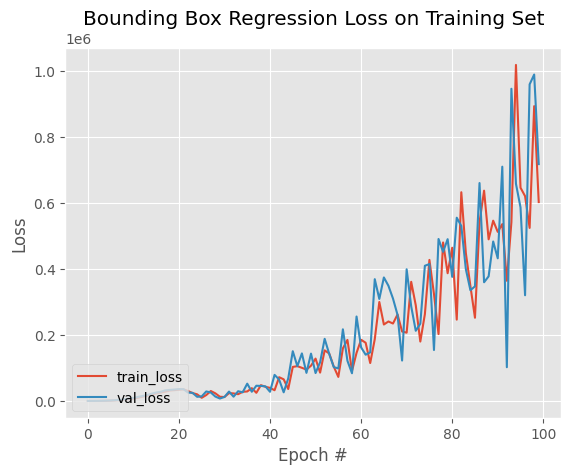

In [ ]:
# serialize the model to disk
print("[INFO] saving object detector model...")
model.save("vgg19_21022008", save_format="h5")
# plot the model training history
N = NUM_EPOCHS

# Định nghĩa đường dẫn để lưu biểu đồ
plt.style.use("ggplot")

# Vẽ biểu đồ
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Bounding Box Regression Loss on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(PLOT_PATH)

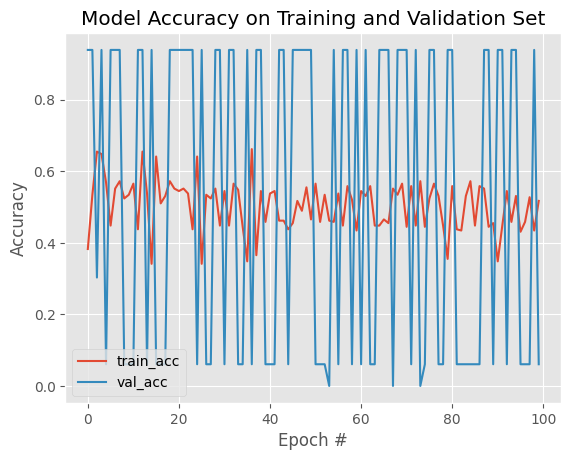

In [ ]:
plt.figure()
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Model Accuracy on Training and Validation Set")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.savefig("acc_plot.png")

2/2 [==============================] - 0s 154ms/step


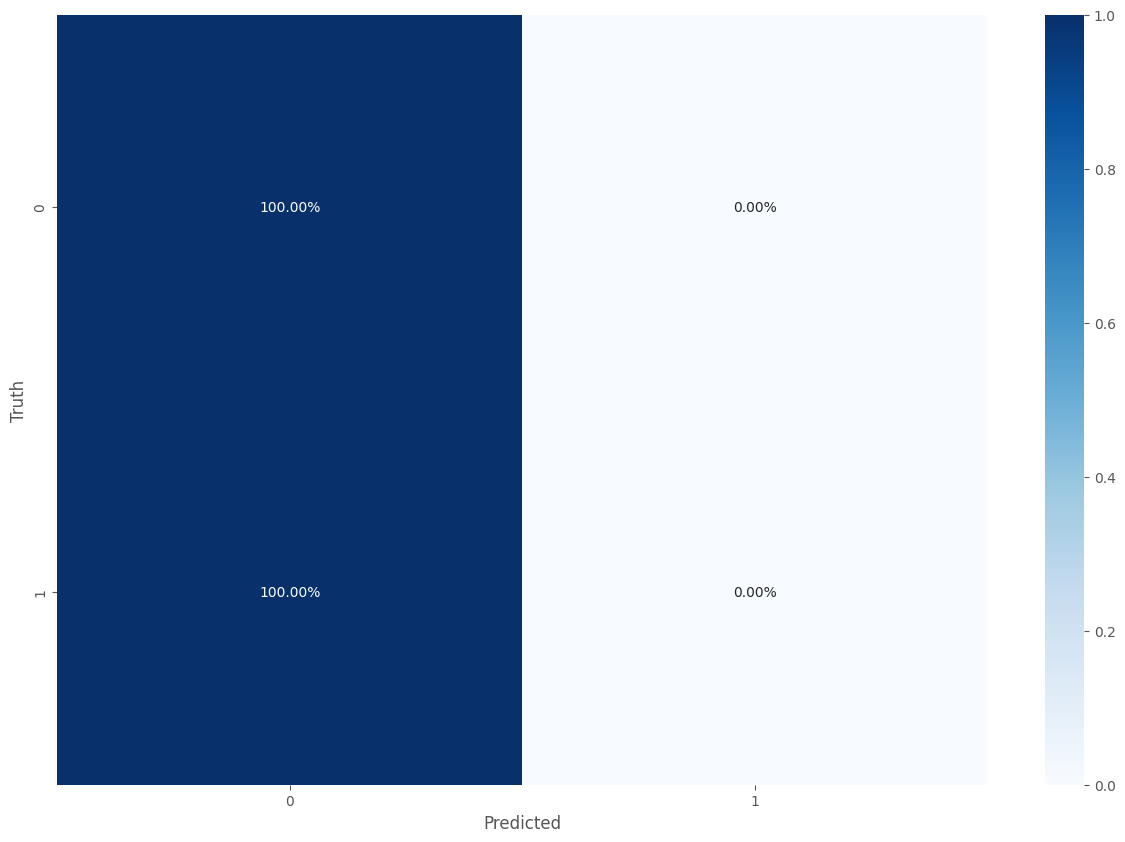

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict the values from the validation dataset
Y_pred = model.predict(testImages)

# Convert predictions classes to one hot vectors
# Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_pred_classes = np.argmax(Y_pred, axis=1)

# Convert validation observations to one hot vectors
Y_true = np.argmax(testTargets, axis=1)

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# Convert confusion matrix to percentages (phần trăm)
confusion_mtx_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix
plt.figure(figsize=(15,10))
# sns.heatmap(confusion_mtx, annot=True, fmt='d')
sns.heatmap(confusion_mtx_percent, annot=True, fmt='.2%', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

# **Dự đoán**

In [ ]:
from google.colab.patches import cv2_imshow
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
import numpy as np
import mimetypes
import argparse
import imutils
import cv2
import os

In [ ]:
print("[INFO] loading object detector...")
model = load_model(MODEL_PATH)

[INFO] loading object detector...


1/1 [==============================] - 0s 168ms/step


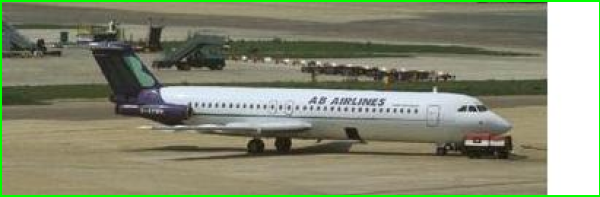

In [ ]:
image = load_img(imagePath, target_size=(224, 224))
image = img_to_array(image) / 255.0
image = np.expand_dims(image, axis=0)
# make bounding box predictions on the input image
preds = model.predict(image)[0]
(startX, startY, endX, endY) = preds
# load the input image (in OpenCV format), resize it such that it
# fits on our screen, and grab its dimensions
image = cv2.imread(imagePath)
image = imutils.resize(image, width=600)
(h, w) = image.shape[:2]
# scale the predicted bounding box coordinates based on the image
# dimensions
startX = int(startX * w)
startY = int(startY * h)
endX = int(endX * w)
endY = int(endY * h)
# Draw the predicted bounding box
cv2.rectangle(image, (startX, startY), (endX, endY),(0, 255, 0), 2)
# Hiển thị hình ảnh
cv2_imshow(image)